# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`.
El número de pedidos está en la columna `num_orders`.

## Preparación

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
data = pd.read_csv('/datasets/taxi.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [ ]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data=data.sort_index()
print(data.index.is_monotonic_increasing)
data.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data.isnull().sum()

num_orders    0
dtype: int64

In [ ]:
data.duplicated().sum()

26415

## Análisis

<AxesSubplot:xlabel='datetime'>

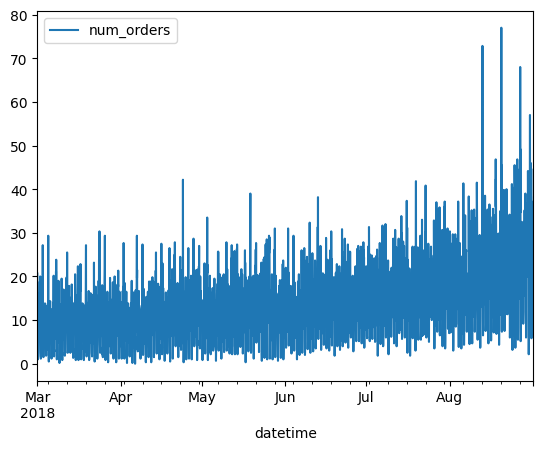

In [ ]:
#Se realiza el remuestreo por hora, y se procede al análisis

data.sort_index(inplace=True)
data = data.resample('1H').mean()
data.plot()

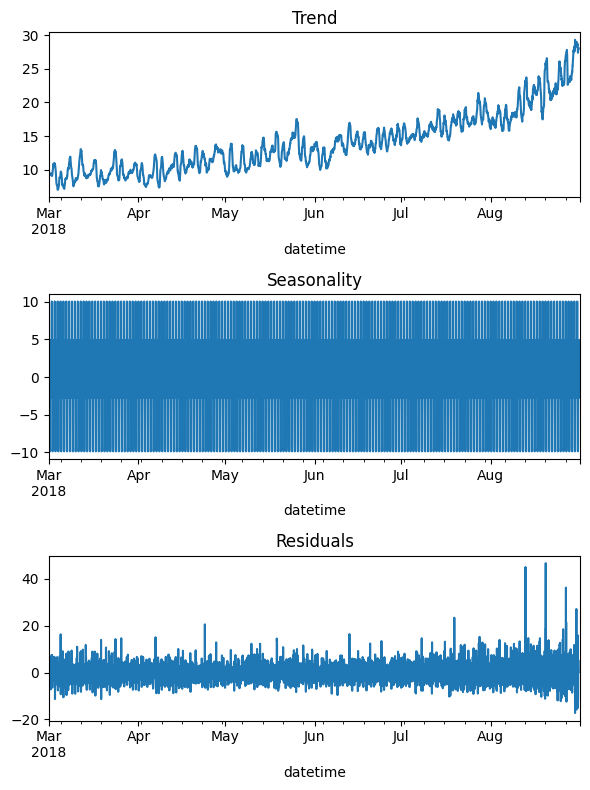

In [ ]:
#Se realiza la descomposición de toda la data, para analizar de manera visual y ver que tendencias tiene

decomposed2 = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)

# Para mostrar el gráfico de manera correcta, especifica su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed2.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed2.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed2.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Se puede observar que los registros tienden a subir conforme avanza el tiempo, misma situación que se visualiza en la tendencia, que se observa que va un poco en ascenso, sin embargo en el apartado de estacionalidad no se puede definir nada en concreto ya que no se observa información de manera clara con toda la data, en los residuos se puede observar que la media permanece en 0, sin embargo tiene algunos picos en ciertos momentos, sin embargo los picos no dicen nada claro, es decir, que pueda haber sucesos que nos aclare que son por tendencia o estacionalidad, por lo que no tiene estacionaridad.

A continuación se procederá a realizar un extracto de días y descomponer la información por tendencia, estacionalidad y residuo, para analizar y comparar los resultados.

<AxesSubplot:xlabel='datetime'>

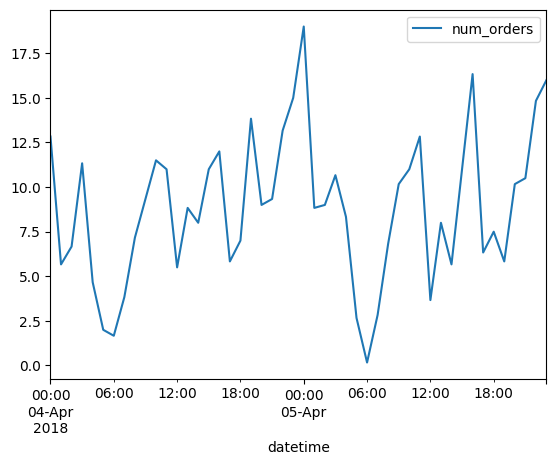

In [ ]:
day_sample=data['2018-04-04':'2018-04-05']
day_sample.plot()

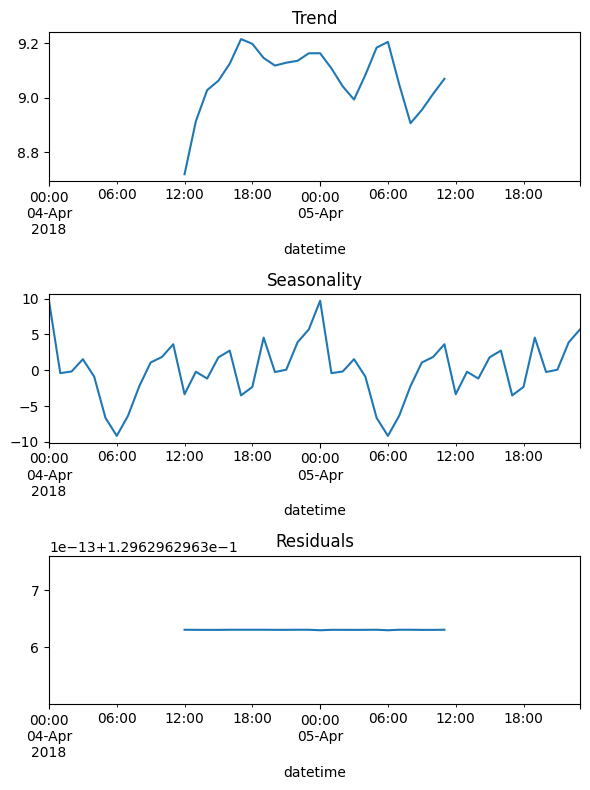

In [ ]:
decomposed = seasonal_decompose(day_sample)
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Para mostrar el gráfico de manera correcta, especifica su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Al** analizar el extracto que se realizó, podemos ver en la gráfica de estacionalidad, si comparamos los resultados desde las 6:00 a las 00:00, es bastante similar, y los residuos permanecen lineales

## Formación

In [ ]:
# Se generan las características mediante una función

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())

make_features(data, 6, 10)
data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,20.666667,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,14.166667,2018,3,1,3,20.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,11.833333,2018,3,1,3,14.166667,20.666667,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,11.000000,2018,3,1,3,11.833333,14.166667,20.666667,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,7.166667,2018,3,1,3,11.000000,11.833333,14.166667,20.666667,NaN,NaN,NaN


In [ ]:
# se realiza la división de los conjuntos

train, test = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()

features_train=train.drop('num_orders', axis=1)
target_train=train['num_orders']
features_test=test.drop('num_orders', axis=1)
target_test=test['num_orders']

In [ ]:
# Modelo de regresión lineal

model = LinearRegression()
model.fit(features_train, target_train)

pred_train=model.predict(features_train)
pred_test=model.predict(features_test)

In [ ]:
# Modelo Bosque aleatorio

modelo1 = RandomForestRegressor(n_estimators=5, random_state=54321)
modelo1.fit(features_train, target_train)

pred_train_mod1 = modelo1.predict(features_train)
pred_test_mod1 = modelo1.predict(features_test)

In [ ]:
#Se entrena el modelo árbol de decisión

modelo2 = DecisionTreeRegressor(random_state=54321)
modelo2.fit(features_train, target_train)

pred_train_mod2=modelo2.predict(features_train)
pred_test_mod2=modelo2.predict(features_test)

In [ ]:
# Se entrena el modelo CatBoostRegressor

model3 = CatBoostRegressor(iterations=800, learning_rate=0.1, depth=6, verbose=0)
model3.fit(features_train, target_train)

pred_cboost_train = model3.predict(features_train)
pred_cboost_test = model3.predict(features_test)

## Prueba

In [ ]:
#Se realizan las pruebas del modelo de regresión lineal

print("RECM para el conjunto de entrenamiento:", sqrt(mean_squared_error(target_train,pred_train)))
print("RECM para el conjunto de prueba:", sqrt(mean_squared_error(target_test,pred_test)))

RECM para el conjunto de entrenamiento: 4.840923332875697
RECM para el conjunto de prueba: 7.998264962461168


In [ ]:
#Se realizan las pruebas del modelo de bosque aleatorio

print("RECM para el conjunto de entrenamiento:", sqrt(mean_squared_error(target_train,pred_train_mod1)))
print("RECM para el conjunto de prueba:", sqrt(mean_squared_error(target_test,pred_test_mod1)))

RECM para el conjunto de entrenamiento: 2.299577701700492
RECM para el conjunto de prueba: 9.656683551024411


In [ ]:
#Se realizan las pruebas del modelo de árbol de decisión

print("RECM para el conjunto de entrenamiento:", sqrt(mean_squared_error(target_train,pred_train_mod2)))
print("RECM para el conjunto de prueba:", sqrt(mean_squared_error(target_test,pred_test_mod2)))

RECM para el conjunto de entrenamiento: 0.0
RECM para el conjunto de prueba: 11.183408579274047


In [ ]:
#Se realizan las pruebas del modelo de catboost regressor

print("RECM para el conjunto de entrenamiento:", sqrt(mean_squared_error(target_train,pred_cboost_train)))
print("RECM para el conjunto de prueba:", sqrt(mean_squared_error(target_test,pred_cboost_test)))

RECM para el conjunto de entrenamiento: 2.1823299148205915
RECM para el conjunto de prueba: 9.408116684354715


## Conclusiones

Observamos que para esta aplicación el modelo más adecuado sería CatBoostRegressor, a pesar de que todos los modelos salieron por debajo de la métrica propuesta en la descripción del proyecto, el modelo CatBoostRegressor es el modelo que arroja el error RECM más pequeño para el conjunto de prueba, y así mismo, también un error bajo para el conjunto de entrenamiento, lo que lo hace el más idóneo a utilizar en el presente proyecto de pedidos de taxis.